In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
train_df, test_df = pd.read_csv('./train_data_balanced.csv'), pd.read_csv('./test_data.csv')
X_train, X_test = train_df.drop('target', axis=1), test_df.drop('target', axis=1)
y_train, y_test = train_df['target'], test_df['target']

In [3]:
# standard
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# CNN
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 
                           tf.keras.metrics.AUC(name='auc')])
    return model

model = build_model((X_train.shape[1],))

In [11]:
# recall
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [12]:
# training
history = model.fit(X_train_scaled, y_train,
                   epochs=100,
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[early_stop, reduce_lr],
                   verbose=1)

Epoch 1/100
88/88 [==============================] - 3s 10ms/step - loss: 0.6138 - accuracy: 0.6847 - auc: 0.7395 - val_loss: 0.6643 - val_accuracy: 0.5235 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 0s 5ms/step - loss: 0.5176 - accuracy: 0.7468 - auc: 0.8063 - val_loss: 0.6386 - val_accuracy: 0.5678 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 0s 5ms/step - loss: 0.4791 - accuracy: 0.7719 - auc: 0.8384 - val_loss: 0.5383 - val_accuracy: 0.7054 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 0s 5ms/step - loss: 0.4548 - accuracy: 0.7841 - auc: 0.8523 - val_loss: 0.5100 - val_accuracy: 0.7304 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 0s 5ms/step - loss: 0.4423 - accuracy: 0.7981 - auc: 0.8617 - val_loss: 0.4745 - val_accuracy: 0.7618 - val_auc: 0.0000e+00 - lr: 0.0010
Epoch 6/100
88/88 [==============================

Epoch 44/100
88/88 [==============================] - 0s 5ms/step - loss: 0.2494 - accuracy: 0.8987 - auc: 0.9578 - val_loss: 0.2537 - val_accuracy: 0.9051 - val_auc: 0.0000e+00 - lr: 4.0000e-05
Epoch 45/100
88/88 [==============================] - 0s 5ms/step - loss: 0.2516 - accuracy: 0.8991 - auc: 0.9566 - val_loss: 0.2615 - val_accuracy: 0.9009 - val_auc: 0.0000e+00 - lr: 4.0000e-05
Epoch 46/100
88/88 [==============================] - 0s 5ms/step - loss: 0.2535 - accuracy: 0.8946 - auc: 0.9563 - val_loss: 0.2569 - val_accuracy: 0.9009 - val_auc: 0.0000e+00 - lr: 4.0000e-05
Epoch 47/100
88/88 [==============================] - 0s 5ms/step - loss: 0.2546 - accuracy: 0.8946 - auc: 0.9559 - val_loss: 0.2552 - val_accuracy: 0.8994 - val_auc: 0.0000e+00 - lr: 4.0000e-05
Epoch 48/100
88/88 [==============================] - 0s 5ms/step - loss: 0.2577 - accuracy: 0.8928 - auc: 0.9552 - val_loss: 0.2487 - val_accuracy: 0.9058 - val_auc: 0.0000e+00 - lr: 4.0000e-05
Epoch 49/100
88/88 [=====

In [13]:
# evaluating
print("\nEvaluating on test set:")
test_loss, test_acc, test_auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating on test set:
Test Accuracy: 0.9143
Test AUC: 0.9337


In [16]:
# evaluate
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

46/46 [==============================] - 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1168
           1       0.82      0.74      0.77       291

    accuracy                           0.91      1459
   macro avg       0.88      0.85      0.86      1459
weighted avg       0.91      0.91      0.91      1459


Confusion Matrix:
[[1120   48]
 [  77  214]]

ROC AUC Score: 0.9341


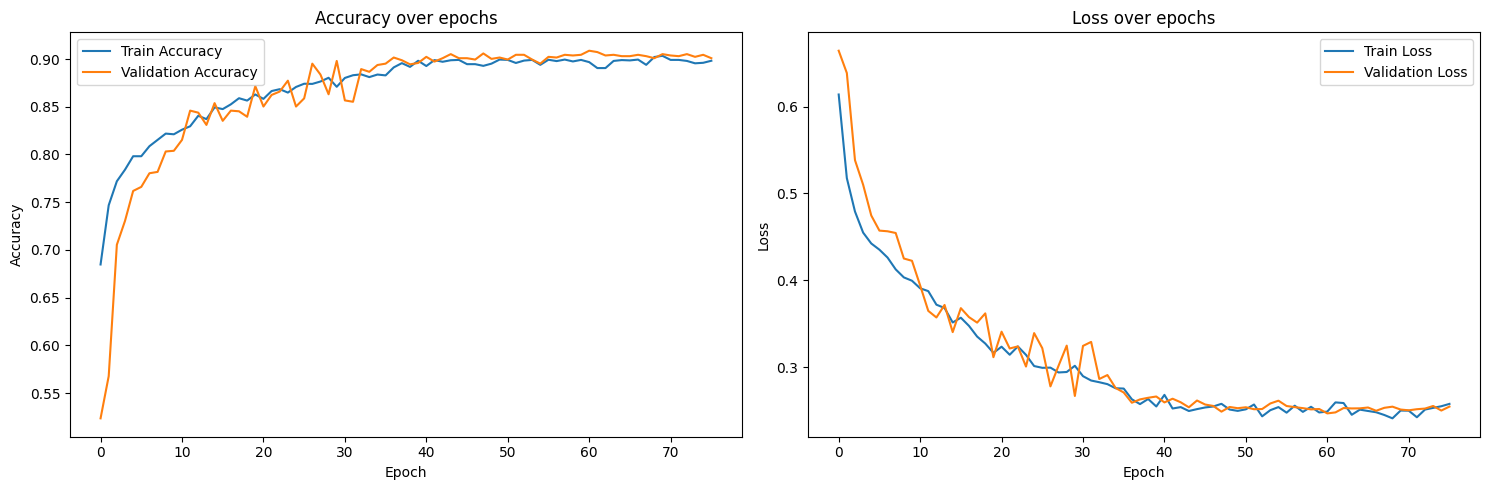

In [18]:
# training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()



plt.tight_layout()
plt.show()